**Step 1: Importing Libraries**

We begin by importing the necessary Python libraries for data handling, preprocessing, visualization and model building: Pandas, Numpy, Matplotlib, Seaborn, and Sklearn.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

**Step 2: Load and Explore the Dataset**

Load the dataset into a pandas DataFrame and examine its structure. The dataset contains sales data for 10 stores and 50 products over five years.

In [ ]:
df = pd.read_csv('/content/sample_data/StoreDemand.csv')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [ ]:
df.shape

(913000, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


**Step 3: Feature Engineering**

There are times when multiple features are provided in the same feature or we have to derive some features from the existing ones. We will also try to include some extra features in our dataset so, that we can derive some interesting insights from the data we have.

Also if the features derived are meaningful then they become a deciding factor in increasing the model's accuracy significantly.

In [ ]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [ ]:
from datetime import date
import holidays

def is_holiday(x):

  india_holidays = holidays.country_holidays('IN')

  if india_holidays.get(x):
    return 1
  else:
    return 0

df['holidays'] = df['date'].apply(is_holiday)
df.head()

,date,store,item,sales,year,month,day,holidays
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,0


In [8]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,0,0.5,0.866025


In [9]:
from datetime import datetime

def which_day(year, month, day):

	d = datetime(year,month,day)
	return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],
													x['month'],
													x['day']),
								axis=1)
df.head()


,date,store,item,sales,year,month,day,holidays,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,0,0.5,0.866025,5


In [10]:
df.drop('date', axis=1, inplace=True)

**Step 4: Exploratory Data Analysis**

EDA analyzes the data using visual techniques. It is used to discover trends, and patterns or to check assumptions with the help of statistical summaries and graphical representations.  We have added some features to our dataset using some assumptions.

Now let's check the unique values in the store and item column using nunique().

In [11]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

From here we can conclude that there are 10 unique stores and they sell 50 different products.

Now, let's analyze the relationship between various features and sales performance by visualizing.

* plt.subplots() is used to creates a figure to accommodate multiple subplots
* df.groupby(col).mean()['sales'].plot.bar() groups the data by current column and calculate the mean sales of each group and plot a bar chart to show the averages for each category of features.

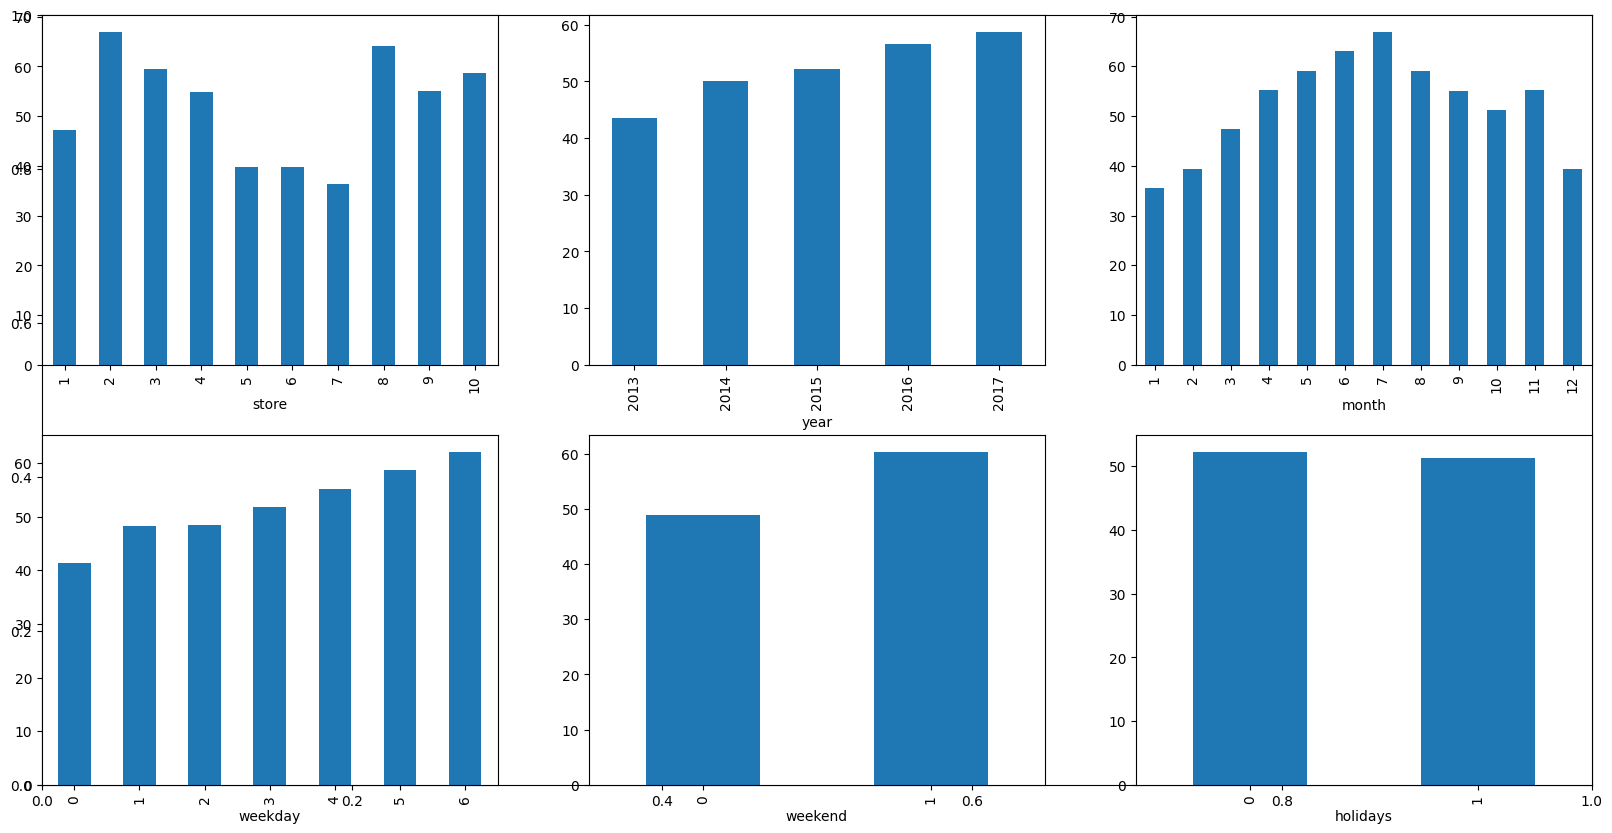

In [12]:
df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
features = ['store', 'year', 'month', 'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()

Now let's check the variation of stock as the month closes to the end using line plot.

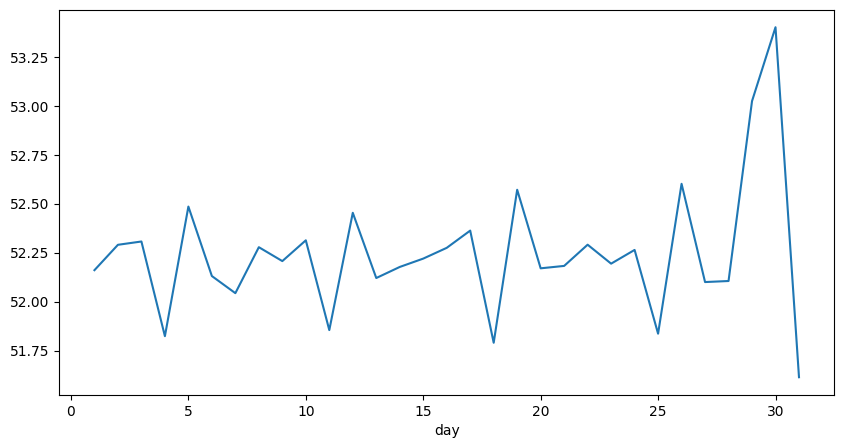

In [13]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

Let's draw the simple moving average for 30 days period. Plotting simple moving average with help to smooth out short-term fluctuations and highlight longer-term trend or cycles in the data.

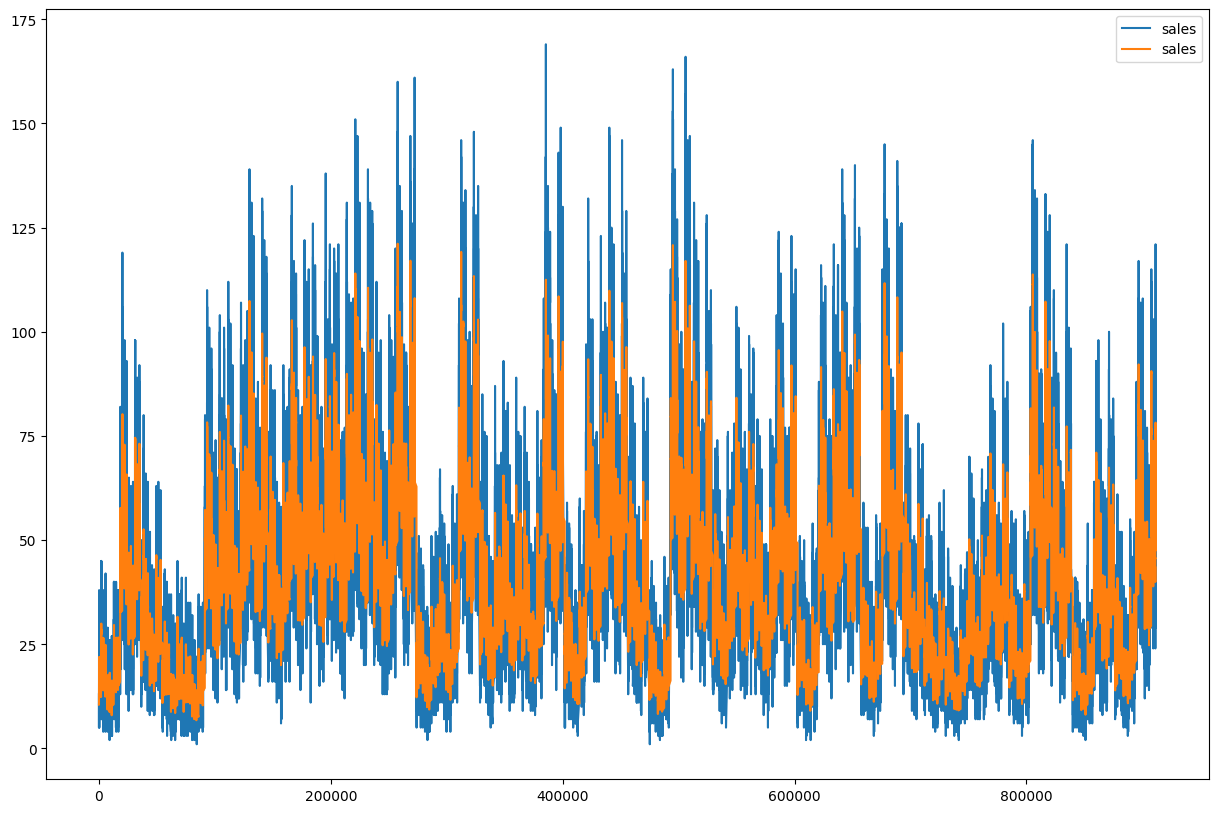

In [14]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

As the data in the sales column is continuous let's check the distribution of it and check whether there are some outliers in this column or not. For this we are using distplot and boxplot.

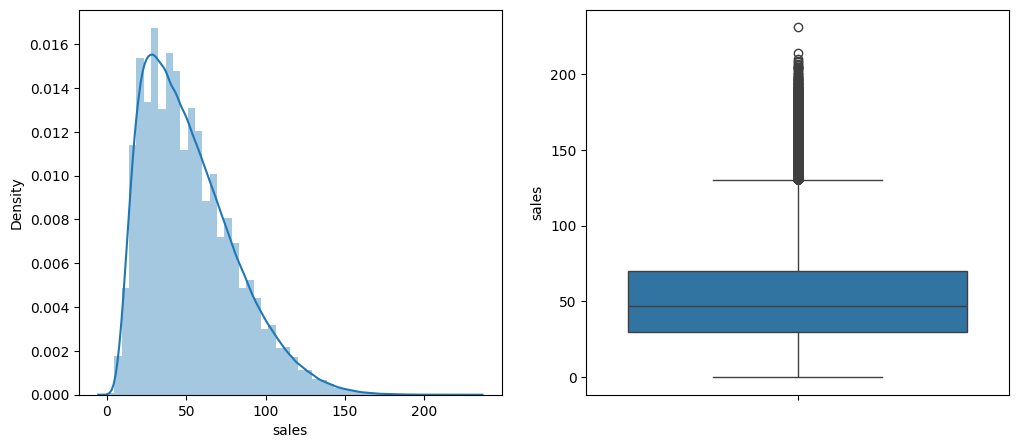

In [ ]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

We can observe that the distribution is right skewed and the dataset contains outliers.

Now, let's check the correlation between the features of the data and added a filter to identify only the highly correlated features. For computing the correlation between the features of the dataset, we use corr() function.

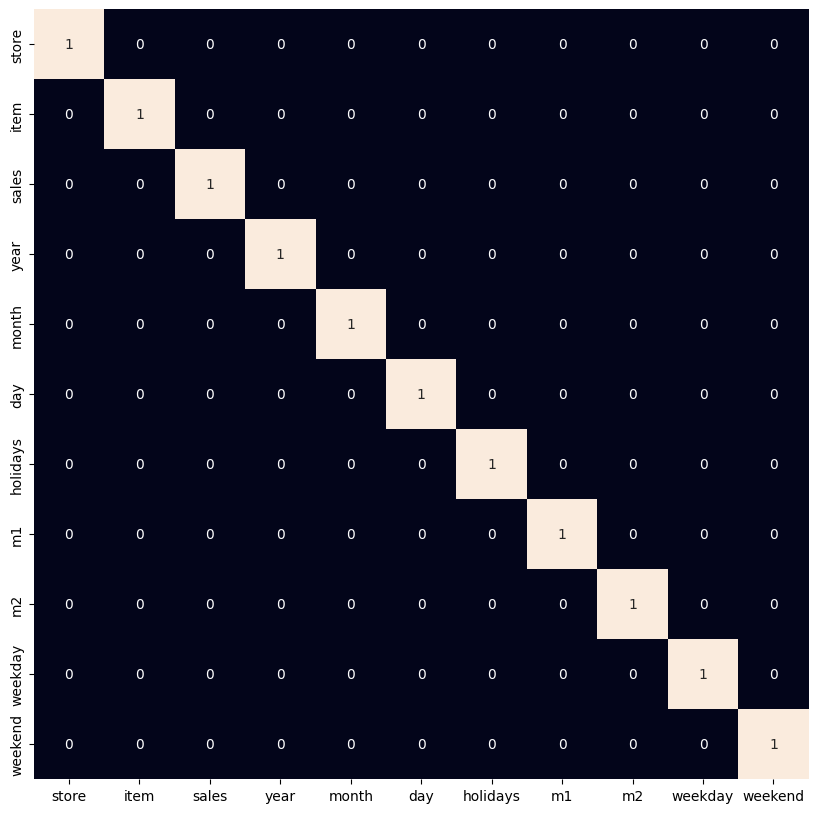

In [ ]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8,
		annot=True,
		cbar=False)
plt.show()

As we observed earlier let's remove the outliers which are present in the data.

In [ ]:
df = df[df['sales']<140]

In [ ]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values


X_train, X_val, Y_train, Y_val = train_test_split(features, target,
												test_size = 0.05,
												random_state=22)
X_train.shape, X_val.shape

((861170, 9), (45325, 9))

Normalizing the data before feeding it into machine learning models helps us to achieve stable and fast training.

In [ ]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

We have split our data into training and validation data also the normalization of the data has been done. Now let's train machine learning models and select the best out of them using the validation dataset.

For this implementation, we have used Linear Regression, XGBoost, Lasso Regression and Ridge Regression.

In [ ]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for i in range(4):
	models[i].fit(X_train, Y_train)

	print(f'{models[i]} : ')

	train_preds = models[i].predict(X_train)
	print('Training Error : ', mae(Y_train, train_preds))

	val_preds = models[i].predict(X_val)
	print('Validation Error : ', mae(Y_val, val_preds))
	print()

LinearRegression() : 
Training Error :  20.902989838083602
Validation Error :  20.97163963254154

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  6.902142131234314
Validation Error :  6.9201690247120675

Lasso() : 
Training Error :  21.01502960996576
Validation Error :  21.071517

After training and evaluating the models, we observe that XGBoost performs the best with the lowest validation error. This demonstrates the power of ensemble methods in capturing complex patterns in sales data.